In [1]:
# Author: Pedro Herruzo
# Copyright 2021 Institute of Advanced Research in Artificial Intelligence (IARAI) GmbH.
# IARAI licenses this file to You under the Apache License, Version 2.0
# (the "License"); you may not use this file except in compliance with
# the License. You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Weather4cast Onboarding

In this notebook you will learn

0. Weather4cast Data
1. How to read, explore, and visualize netCDF4 files
    * dependencies: pathlib, sys, netCDF4, numpy, glob, matplotlib
1. Load and transform context variables: *altitudes* and *latitude*/*longitude* 
    * dependencies: same as before
1. Data split in training/validation/test, and list of days with missing time-bins
    * dependencies: pandas, json
1. Data Loader Example
    * dependencies: numpy, pandas, json, xarray, netCDF4, glob, torch.utils.data
1. Generate a valid submission for the Persistence model
    * dependencies: the ones before + h5

Furthermore, you can find all explained methods here ready to use in folder *utils*. 

We also provide the file utils/environment.yml which contains the dependencies above plus a lot more that are not necessary. We recommend installing only the minimal set but we provide an example for comparison.





## 0. Weather4cast Data

Weather4cast provides 3 data sources:
1. **core-w4c**: Core competition data with training, validation and test splits for regions R1, R2, R3, R7, and R8 [get the data](https://www.iarai.ac.at/weather4cast/forums/topic/weather4cast-2021-data-access/)
2. **transfer-learning-w4c**: Transfer Learning competition data with only the test split for regions R4, R5, R6, R9, R610, and R11 [get the data](https://www.iarai.ac.at/weather4cast/forums/topic/w4c-transfer-learning-stage1-data-access/)
3. **statics**: Static data that might be beneficial [get the data](https://www.iarai.ac.at/weather4cast/forums/topic/weather4cast-2021-static-channels-common-files-for-any-competition/)
    * latitudes/longitudes
    * elevation

Participants can participate in both or only one competition. In any case, only the predictions of the test split are requested to be submitted.

In this notebook, we will use the folder paths and parameters defined in **weather4cast/config.py**. Please, set there the paths to the data before starting with the notebook (check the `Start here` section in the README.md if you want to see how).

In [2]:
# ------------
# 1. Set paths to load the config file
# ------------
%load_ext autoreload
%autoreload 2

# we are going to use the data paths defined in weather4cast/config.py
import pathlib
import sys
import os
module_dir = str(pathlib.Path(os.getcwd()).parent)
sys.path.append(module_dir)

import config as cf

config_args = {
    'region_id': 'R3', # region to be used, make sure you have download the data for the corresponding competition
}
params = cf.get_params(**config_args)['data_params']

Using data for region R3 | size: 256 | South West
Europe


## 1. How to read and visualize netCDF4 files

The data for weather4cast comes in the [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) format, which is a standard for self-described array-oriented data for sharing scientific data, commonly used in weather communities.
We show how to access these files using the Python library [netCDF4](https://unidata.github.io/netcdf4-python/) but there are others like [xarray](http://xarray.pydata.org/en/stable/io.html).

### File name and folders format
Each file in weather4cast represents a 15 minutes period of satellite processed observations with a pixel resolution about 4km x 4km. The following is an example of a file path: \
*R1/training/2019055/CRR/S_NWC_CRR_MSG4_Europe-VISIR_20190224T234500Z.nc*

The format corresponds to *region_id/data_split/day_in_year/product/file_name.nc*, where *day_in_year* is the day number in that year (e.g., 2019365 would refer to the last day in 2019). Note that the file itself encodes the following format: 
S_NWC_{**product**}_MSG\*_Europe-VISIR_\*{**date**}T{**time**}Z.nc'. In this case {product=CRR, date=20190224 (which is indeed day_in_year=2019055), time=234500}.

We can use this fact to retrieve any combination of region, product, date (or its corresponding *day_in_year*), and time from our database. An example of this is shown below.
Make sure you are using a *date* that belongs to the corresponding *data_split*.



In [3]:
# ------------
# 1. Set product, date, and time to load
# ------------

# a. import the library to read NetCDF files
import netCDF4
import numpy as np

# b. Set a product, day_in_year and time to
data_split = 'training'
product = 'CTTH'
day_in_year, time = 2019340, '104500'

data_path = params['data_path']
print(f'\ndata path to be used: {data_path}')

# c. show all possible times that can be used
times = [ '{}{}{}{}00'.format('0'*bool(i<10), i, '0'*bool(j<10), j) for i in np.arange(0, 24, 1) for j in np.arange(0, 60, 15)]
print(f'\nAll possible times: {times}')

#print(f'\nParameters from the config file: {params}')



data path to be used: /iarai/home/pedro.herruzo/projects/iarai_github/weather4cast/utils/../data/core-w4c/R3

All possible times: ['000000', '001500', '003000', '004500', '010000', '011500', '013000', '014500', '020000', '021500', '023000', '024500', '030000', '031500', '033000', '034500', '040000', '041500', '043000', '044500', '050000', '051500', '053000', '054500', '060000', '061500', '063000', '064500', '070000', '071500', '073000', '074500', '080000', '081500', '083000', '084500', '090000', '091500', '093000', '094500', '100000', '101500', '103000', '104500', '110000', '111500', '113000', '114500', '120000', '121500', '123000', '124500', '130000', '131500', '133000', '134500', '140000', '141500', '143000', '144500', '150000', '151500', '153000', '154500', '160000', '161500', '163000', '164500', '170000', '171500', '173000', '174500', '180000', '181500', '183000', '184500', '190000', '191500', '193000', '194500', '200000', '201500', '203000', '204500', '210000', '211500', '213000'

Note that not all dates will contain all 96 15-minute time-bins in a day since satellites or post-processing fail to deliver them from time to time. Furthermore, the test data split only contain 4 time-bins, the input data for the expected 32 consecutive predictions (8 hours).

In [4]:
# ------------
# 2. Retrieve the file
# ------------
import glob

# a. use a ~regular expression to find the path with the help of the Python library glob
file = f'S_NWC_{cf.get_prod_name(product)}_MSG*_Europe-VISIR_*T{time}Z.nc'
path = f'{data_path}/{data_split}/{day_in_year}/{product}/{file}'

file_path = glob.glob(path)
assert len(file_path)==1, f" Error with file in {path} ----> all these files were found: {file_path}"
file_path = file_path[0]
print(f'file found: {file_path}')

# b. load the file
ds = netCDF4.Dataset(file_path, 'r')

file found: /iarai/home/pedro.herruzo/projects/iarai_github/weather4cast/utils/../data/core-w4c/R3/training/2019340/CTTH/S_NWC_CTTH_MSG4_Europe-VISIR_20191206T104500Z.nc


In [5]:
# ------------
# 3. Explore the file
# ------------

# print all variables/channels it contains
print('1. variables in the file:', ds.variables.keys())

# get the name of 1 variable and print its shape and properties
var_name = list(ds.variables.keys())[0]
print(f'\n2. shape of {var_name}:', ds[var_name].shape)
print(print(ds[var_name]))

# get the variable tensor using [...], check the type, and print its structure
v = ds[var_name][...]
print('\nvariable type:', type(v), v.shape)
print(f'variable type: {v.dtype} | variable fill_value for missing values: {v.fill_value}')

1. variables in the file: dict_keys(['ctth_pres', 'ctth_alti', 'ctth_tempe', 'ctth_effectiv', 'ctth_method', 'ctth_quality', 'ny', 'nx', 'ishai_skt', 'ishai_quality', 'temperature'])

2. shape of ctth_pres: (256, 256)
<class 'netCDF4._netCDF4.Variable'>
uint16 ctth_pres(ny, nx)
    _FillValue: 65535
    standard_name: air_pressure_at_cloud_top
    long_name: NWC GEO CTTH Cloud Top Pressure
    units: Pa
    valid_range: [    0 11000]
    ancillary_variables: ctth_status_flag  ctth_conditions ctth_quality ctth_pres_pal
    coordinates: lon lat
    add_offset: 0.0
    scale_factor: 10.0
unlimited dimensions: 
current shape = (256, 256)
filling on
None

variable type: <class 'numpy.ma.core.MaskedArray'> (256, 256)
variable type: float32 | variable fill_value for missing values: 65535


### Variable Properties
Each variable has a *type* (uint16 in the previous case), a *standard_name*, units (Pa), a *valid_range* (0, 11000), an *add_offset* (0), and a *scale_factor* (10). The last is pretty important since it scales the variable accordingly. For instance, the real range of this variable is 10 times the valid_range, so when retrieving the data it will be in the range (0, 110000), which can't be uint16 anymore. This operation is done automatically by netCDF when accessing to a variable and it's called *unpack*, which refers to loading a light integer and convert it to a float in the expected range. Note that this is not normalizing the variable into the rage [0, 1] but just to [*add_offset, max(valid_range) x scale_factor + add_offset*].

Another important attribute is *_FillValue*, the value to set those pixels with missing values to (e.g., each pixel with a missing value will be set to 65535 in this case).

### Variables as masked numpy arrays

NetCDF uses [masked numpy arrays](https://numpy.org/doc/stable/reference/maskedarray.generic.html) to store values. This data structure contains a mask per pixel with missing values represented by True. The mask can be retrieved by *v.mask* and the data by *v.data* (WARNING: This will set missing values to *_FillValue*). If you want any other value to be set for missing value, just get the data using *v.filled(np.nan)* (setting them to NumPy's NaN in this example). 

IMPORTANT: 
1. Set a filling value for each variable to treat missing values or use the default value
1. Scale each variable if you believe it's important before feeding your model (e.g., between 0 and 1)

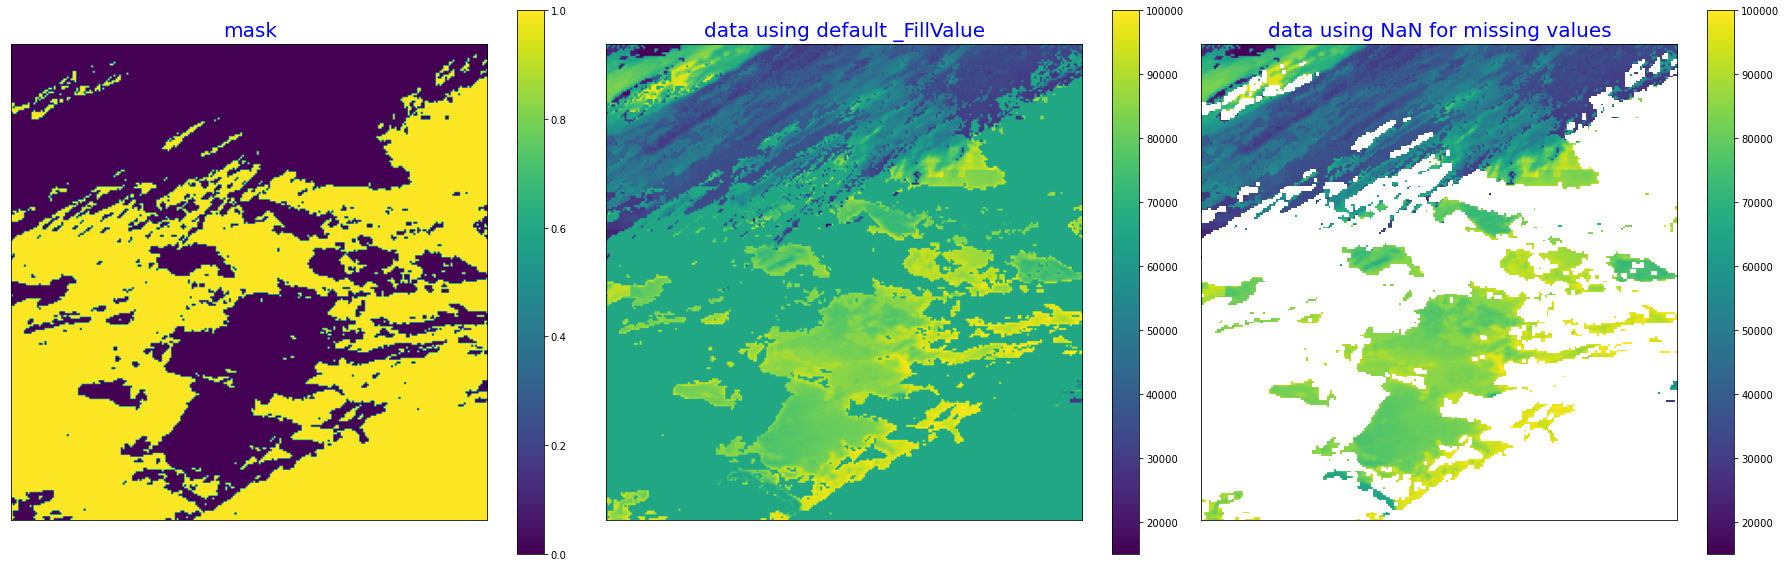

In [6]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

def plot_N(images, texts):
    fig = plt.figure(figsize=(32, 10))
    gs = GridSpec(nrows=1,ncols=len(images))
    gs.update( hspace = 0.5, wspace = 0.)

    for i in range(len(images)):
        ax = fig.add_subplot(gs[0, i])
        im = ax.imshow(images[i])
        plt.colorbar(im, ax=ax)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(128, -5,  texts[i], size=20, ha="center", color='Blue')
        
    plt.show()  

images = [v.mask, v.data, v.filled(np.nan)]
texts = ['mask', 'data using default _FillValue', 'data using NaN for missing values']
plot_N(images, texts)

## 2. Load and transform context variables: *altitudes* and *latitude*/*longitude* 

We are going to load context static variables from the path defined in config.py, next we will visualize them and then crop them to the region of interest and visualize them again.

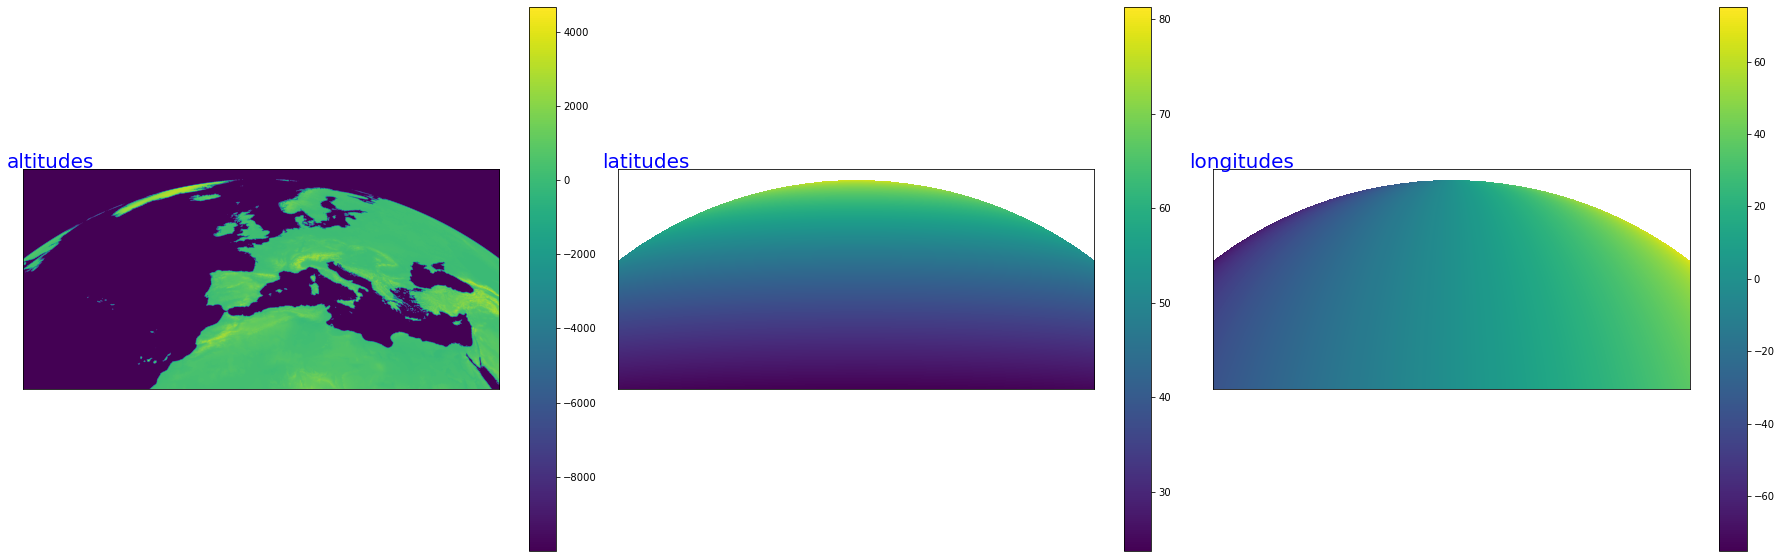

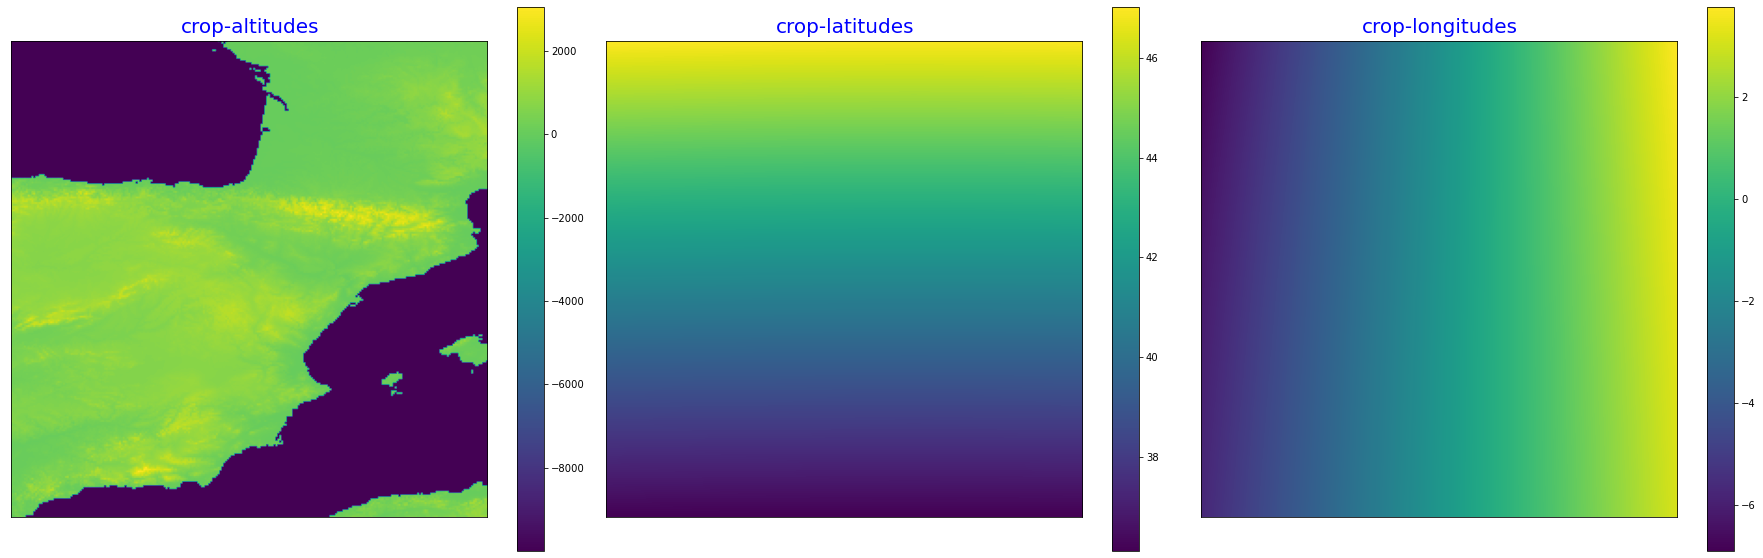

In [7]:
# ------------
# 1. Get paths and prepare region crop (using weather4cast/config.py)
# ------------
region_crop = params['crop_static']
latlon_path = params['static_paths']['l']
altitudes_path = params['static_paths']['e']
altitudes_shape = (1019, 2200)

# ------------
# 2. Retrieve files
# ------------
# a. altitudes is a binary file
altitudes = np.fromfile(altitudes_path, dtype=np.float32)
altitudes = altitudes.reshape(altitudes_shape[0], altitudes_shape[1])

# b. lat/lon is a NetCDF file
latlon = netCDF4.Dataset(latlon_path, 'r')
latlon = [latlon[att][...].data[0] for att in ['latitude', 'longitude']]
latlon = np.asarray(latlon)

# ------------
# 3. Viz context variables
# ------------
images = [altitudes, latlon[0], latlon[1]]
texts = ['altitudes', 'latitudes', 'longitudes']
plot_N(images, texts)

# ------------
# 3. Crop and Viz context variables
# ------------
# a. crop
def mk_crop(product, x_start, y_start, size=256):
    return product[y_start: y_start+size, x_start: x_start+size]
altitudes = mk_crop(altitudes, **region_crop)
latlon = [mk_crop(l, **region_crop) for l in latlon]
latlon = np.asarray(latlon)

# b. viz
images = [altitudes, latlon[0], latlon[1]]
texts = ['crop-altitudes', 'crop-latitudes', 'crop-longitudes']
plot_N(images, texts)


You might use these variables of context to train your models and boost transfer learning!

## 3. Data split in training/validation/test

1. We defined a file (splits.csv) containing all days in the period 15 Feb 2019 - 14 Feb 2020 (i.e., *day_in_year* in he period 2019046 - 2020045)
    * We note that for training and validation all available time-bins are provided
2. For test days, we defined a file (test_split.json) defining input/output time-bins sequences
    * We note that for a test day we only provide the input sequence that consists of 4 time-bins (1h)


In [8]:
import pandas as pd
import json

# ------------
# 1. Get paths & files
# ------------
def read_splits(path_splits, path_test_split=''):
    """ read dates splits with pandas and test_splits with json """
    df = pd.read_csv(path_splits, index_col=0)
    with open(path_test_split) as data_file:    
        test_splits = json.load(data_file)
    return df, test_splits

test_sequences = params['test_splits']
data_splits = params['train_splits']
data_splits, test_sequences = read_splits(data_splits, test_sequences)

# ------------
# 2. Show a sample of the data split 
# ------------
print('\nData splits:')
display(data_splits)

# ------------
# 3. Show a sample of the test split 
# ------------
# a. get id_day from the first test day & make it 3 digits if only contains 2
#test_id_day = str(data_splits[data_splits.split=='test'].iloc[0]['id_day'])
#test_id_day = '0'*(3-len(test_id_day)) + test_id_day
#print(f'selected test day: {test_id_day}')

test_id_day = str(data_splits[data_splits.split=='test'].iloc[0]['id_date'])
test_id_day = test_id_day[-3:]
print(f'selected test day: {test_id_day}')

print('Test days sequences example:')

print(f'Description of the input sequence of length 32 for the day: {test_id_day}')
for bin_id, description in test_sequences[test_id_day]['bins_in'].items():
    print(bin_id, description)


Data splits:


,id_date,split_id,split,id_day,date
0,2019046,0,training,46,20190215
1,2019047,2,test,47,20190216
2,2019048,2,test-next,48,20190217
3,2019049,0,training,49,20190218
4,2019050,0,training,50,20190219
...,...,...,...,...,...
360,2020041,0,training,41,20200210
361,2020042,2,test,42,20200211
362,2020043,0,training,43,20200212
363,2020044,0,training,44,20200213


selected test day: 047
Test days sequences example:
Description of the input sequence of length 32 for the day: 047
0 {'id_day': '047', 'id_bin': 68, 'time_bin': '170000', 'date': '20190216'}
1 {'id_day': '047', 'id_bin': 69, 'time_bin': '171500', 'date': '20190216'}
2 {'id_day': '047', 'id_bin': 70, 'time_bin': '173000', 'date': '20190216'}
3 {'id_day': '047', 'id_bin': 71, 'time_bin': '174500', 'date': '20190216'}


In the *time_bin* field we can find the time of the input sequence and its corresponding time-bin id *id_bin*. The same can be done for the expected target prediction:

In [9]:
print(f'Description of the expected target sequence of length 32 for the day: {test_id_day}')
for bin_id, description in test_sequences[test_id_day]['bins_out'].items():
    print(bin_id, description)

Description of the expected target sequence of length 32 for the day: 047
0 {'id_day': '047', 'id_bin': 72, 'time_bin': '180000', 'date': '20190216'}
1 {'id_day': '047', 'id_bin': 73, 'time_bin': '181500', 'date': '20190216'}
2 {'id_day': '047', 'id_bin': 74, 'time_bin': '183000', 'date': '20190216'}
3 {'id_day': '047', 'id_bin': 75, 'time_bin': '184500', 'date': '20190216'}
4 {'id_day': '047', 'id_bin': 76, 'time_bin': '190000', 'date': '20190216'}
5 {'id_day': '047', 'id_bin': 77, 'time_bin': '191500', 'date': '20190216'}
6 {'id_day': '047', 'id_bin': 78, 'time_bin': '193000', 'date': '20190216'}
7 {'id_day': '047', 'id_bin': 79, 'time_bin': '194500', 'date': '20190216'}
8 {'id_day': '047', 'id_bin': 80, 'time_bin': '200000', 'date': '20190216'}
9 {'id_day': '047', 'id_bin': 81, 'time_bin': '201500', 'date': '20190216'}
10 {'id_day': '047', 'id_bin': 82, 'time_bin': '203000', 'date': '20190216'}
11 {'id_day': '047', 'id_bin': 83, 'time_bin': '204500', 'date': '20190216'}
12 {'id_day'

Note that in this example the requested prediction horizon of 8h expands across two different days (from *id_bin* 72 up to 95 is *date* 20190216 and from there time-bins correspond to the next day).

3. List of days with missing time-bins.

As mentioned above, any day can have missing images (each corresponding to a 15-minute time-bin) due to satellite or post-processing failure. Luckily there not many missing and we have compiled them all in a file. 

We can use this file when creating a sample to train by using only input sequences without any missing time-bin, i.e., using input sequences with not-interrupted 1-hour measurements (4 consecutive 15-minute time-bins). Below we show the days with missing slots and an example of how to use them to build samples with uninterrupted input sequences. 

For the output (a sequence of 32 time-bins), we don't set any restriction since we are going to build our example based on a single time-bin prediction condioned by the *lead time* to predict. In other words, if input has time-bins $(t-3, t-2, t-1, t)$ and output $(t+1, t+2, ..., t+32)$, our example predicts a single image by providing the input time bins and conditioning the prediction by a single *lead time*, e.g., by $t+5$ when predicting this slot. In this way, if time-bin $t+8$ is missing, we don't care since we just don't ask for this prediction at training time.

Note that all test days have all input time-bins informed and you will always be requested to predict all 32 future time-bins.

In [10]:
# open and print the black list
with open('blacklist.json') as data_file:    
    blacklist = json.load(data_file)
for k, v in blacklist.items():
    print(k, v)

2019056 [51, 52, 53, 54, 58]
2019071 [52, 53, 54, 55]
2019095 [51, 95]
2019096 [95]
2019100 [95]
2019102 [48, 41, 95]
2019103 [19, 95]
2019105 [95]
2019108 [95]
2019109 [95]
2019111 [95]
2019126 [63]
2019134 [41]
2019144 [56]
2019151 [88]
2019182 [59, 61]
2019183 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
2019229 [29]
2019232 [88, 89, 90]
2019236 [63]
2019238 [69, 70, 71, 73, 74]
2019239 [74, 75, 78]
2019242 [69]
2019256 [47]
2019263 [77]
2019281 [42]
2019288 [48]
2019289 [49]
2019315 [43, 44, 56, 57, 58]
2019180 [79, 80]
2019299 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
2019352 [47]
2020029 [9]


The blacklist shows the *id_bin* missing for a given *day_in_year*. This list is the **union** of all missing time-bins for all products, which means that if any product has a missing time-bin, we won't use any other product for that time-bin. If you want, you could change this to your model to work even with a missing value of a product, **this is only an example**.

For the creation of our dataset, we will show a simple example that avoids input sequences with missing time-bins. To indicate the input sequence and the *lead time* to predict, we will use a list of triplets (*d, i, o*), where: 
* *d* stands for *day_in_year* to read the data from (for all days in training and validation splits)
* *i* stands for the input index *id_bin* to start loading 4 consecutive time-bins to define the input sequence of 1 hour (from 0 to 3)
* *o* stands for the *lead time* to predict (from 0 to 31)

In this way, we can use the blacklist to append only triplets (*d, i, o*) such that:
* *i*, *i+1*, *i+2*, *i+3* are not in the blacklist
* *o* is not in the blacklist

The following is a Python block that performs this given a set of days, e.g., training days.

In [11]:
def get_triple_idxs_w_blacklist(days, bins_to_predict=32, day_bins=96, len_seq_in=4, black_list_path='blacklist.json', verbose=False):

    triples = []
    with open(black_list_path) as data_file:
        # convert key 'dates' to integer
        black_list = json.load(data_file)
        black_list = {int(k): v for k, v in black_list.items()}
    
    # range for the input sequence
    in_range = day_bins-(len_seq_in+bins_to_predict-1)
    
    # for each day 'd', AND each starting timebin index 'i'
    for d in days:
        for i in range(in_range):
            seq_in_black = False
            
            # if day is in the blacklist AND any input frame in the sequence is missing
            # -->  we will block this sequence
            if d in black_list.keys():
                
                seq_bins = [i+j for j in range(len_seq_in)]
                timebins_in_black = [idx for idx in seq_bins if idx in black_list[d]]
                
                if len(timebins_in_black)>0:
                    seq_in_black = True
                    if verbose:
                        print(i, seq_bins, timebins_in_black, black_list[d])
            
            # only consider sequences with input frames not in the black_list
            if not seq_in_black:
                
                # even if input sequence is not in the black_list
                # we will only consider the triplet if the output is not in the blacl_list
                for o in range(bins_to_predict):
                    out_in_black = False
                    if d in black_list.keys():
                        if i+len_seq_in+o in black_list[d]:
                            out_in_black = True
                    
                    if not out_in_black:
                        triples.append((d, i, o))
                    else:
                        if verbose:
                            print("--> output")
                            print((d, i, i+o, black_list[d]))
            else: 
                if verbose:
                    print("input: ")
                    print(d, i)
                    print()

    return triples

# get triplets with no input or output in the blacklist
triplets = get_triple_idxs_w_blacklist(data_splits[data_splits.split=='training']['id_date'].values)

# print the first 35 index to load 35 sequnces
print(triplets[:35])

[(2019046, 0, 0), (2019046, 0, 1), (2019046, 0, 2), (2019046, 0, 3), (2019046, 0, 4), (2019046, 0, 5), (2019046, 0, 6), (2019046, 0, 7), (2019046, 0, 8), (2019046, 0, 9), (2019046, 0, 10), (2019046, 0, 11), (2019046, 0, 12), (2019046, 0, 13), (2019046, 0, 14), (2019046, 0, 15), (2019046, 0, 16), (2019046, 0, 17), (2019046, 0, 18), (2019046, 0, 19), (2019046, 0, 20), (2019046, 0, 21), (2019046, 0, 22), (2019046, 0, 23), (2019046, 0, 24), (2019046, 0, 25), (2019046, 0, 26), (2019046, 0, 27), (2019046, 0, 28), (2019046, 0, 29), (2019046, 0, 30), (2019046, 0, 31), (2019046, 1, 0), (2019046, 1, 1), (2019046, 1, 2)]


As an example, the triplet (2019046, 0, 15) give us the information to load the following input/output sequence to train with:
* *day_in_year* 2019046
* load input images from time-bins 0 (00:00:00h), 1 (00:15:00h), 2 (00:30:00h), and 3 (00:45:00h)
* load target image to predict with *lead time* 15, so 04:45:00h (*lead time* 0 would be 01:00:00h, the next *time bin* from the last input image)

Note that we can create a dataset that uses the list of triplets to load training samples.

## 4. Data Loader Example

In this section, we will implement a basic data loader for PyTorch that allows loading batches from:
* Different products (CTTH, CRR, ASII, CMA)
* Static Context Variables (altitudes and latitudes/longitudes)

In order to do so, we will use the following auxiliar modules:
* data_utils.py defines how to load a sequence of products:
    * How to load a file for 1 product (like in section 1)
    * Example of a transformation of a product (normalization and filling missing values)
    * Pack different products (all in the same 15-minute time-bin) in a single NumPy array
    * Pack a sequence of time-bin images
    * Avoid loading sequences with input images missing (like in section 3)
* context_variables.py defines:
    * How to load and crop context variables (like in section 2 but this time using xarray to load them, so we have an example with this library too)
    * Example of a transformation of context variables (normalization)

In [13]:
import numpy as np
from torch.utils.data import Dataset
import data_utils
from context_variables import get_static

def sum_1_year(date):
    """ sum 1 year to `date`
    """
    year_1 = int(date/1000)+1
    date = str(year_1) + str(date)[-3:]
    return int(date)
class NWCSAF(Dataset):
    
    def __init__(self, data_split, products, target_vars,
                 spatial_dim, collapse_time=True, 
                 len_seq_in=4, bins_to_predict=32, day_bins=96,
                 region_id=None,  preprocess=None,
                 crop_in=None, crop_out=None,
                 extra_data='', crop_static=None, static_paths=None,
                 data_path='',
                 train_splits='splits.csv', 
                 test_splits='test_split.json', 
                 black_list_path='blacklist.json', 
                 heldout_data = False, **kwargs):
        
        self.channel_dim = 1 # specifies the dimension to concat multiple channels/variables

        # data dimensions
        self.spatial_dim = spatial_dim
        self.collapse_time = collapse_time
        self.len_seq_in = len_seq_in
        self.bins_to_predict = bins_to_predict
        self.day_bins = day_bins
        self.day_strings = ['{}{}{}{}00'.format('0'*bool(i<10), i, '0'*bool(j<10), j) for i in np.arange(0, 24, 1) for j in np.arange(0, 60, 15)]
        
        # type of data & processing variables
        self.products = products
        self.target_vars = target_vars
        self.region_id = region_id
        self.preprocess = preprocess
        self.crop_in, self.crop_out = crop_in, crop_out
        self.heldout_data = heldout_data
        
        # load extra variables if any 
        self.extra_data, self.static_tensor, self.static_desc = [], [], []
        if extra_data != '':
            self.extra_data = extra_data.split('-')
            self.static_tensor, self.static_desc = get_static(self.extra_data, self.len_seq_in, static_paths, 
                                                              crop=crop_static, channel_dim=self.channel_dim)
        
        # data splits to load (training/validation/test)
        self.data_path = data_path + f'/{data_split}'
        self.data_split = data_split
        self.day_paths, self.test_splits = data_utils.read_splits(train_splits, test_splits)
        
    
        # prepare all elements to load - batch idx will use the object 'self.idx'
        if self.data_split != 'test':
            self.day_paths = self.day_paths[self.day_paths.split==self.data_split].reset_index()
            self.idxs = data_utils.get_triple_idxs_w_blacklist(self.day_paths['id_date'].values, self.bins_to_predict, 
                                                               self.day_bins, self.len_seq_in, 
                                                               black_list_path=black_list_path)
        else:
            test_dates = self.day_paths[self.day_paths.split==self.data_split].reset_index()
            self.idxs = data_utils.get_test_triplets(test_dates['id_date'].sort_values().values, 
                                                     self.test_splits, 
                                                     self.bins_to_predict)
            self.day_paths = self.day_paths[self.day_paths.split.isin(['test', 'test-next'])].reset_index()
            
            

    def __len__(self):
        """ total number of samples (sequences of in:4-out:1 in our case) to train """
        return len(self.idxs)
    
    def load_in_seq(self, day_id, in_start_id, lead_time):
        """ load the input sequence """
        
        # 1. load nwcsaf products & metadata
        in_seq, in_info = data_utils.get_sequence_netcdf4(self.len_seq_in, in_start_id, day_id, 
                                                         self.products, self.data_path, self.target_vars, 
                                                         crop=self.crop_in, preprocess=self.preprocess['source'], 
                                                         day_bins=self.day_bins, 
                                                         sorted_dates=self.day_paths.id_date.sort_values().values)
        
        # 2. Load extra features
        if len(self.static_tensor)!=0: # 2.1 static features
            in_seq = np.concatenate((in_seq, self.static_tensor), axis=self.channel_dim)
            in_info['channels'] += self.static_desc

        # 3. Load lead time to predict and normalize it
        data = np.ones(shape=(self.len_seq_in, 1, self.spatial_dim[0], self.spatial_dim[1]))
        data[...] = (lead_time+1)/self.bins_to_predict
        in_seq = np.concatenate((in_seq, data), axis=self.channel_dim)
        in_info['channels'] += ['lead_time']
        
        # 4. Collapse time if needed and set the appropriate data type for learning
        if self.collapse_time:
            in_seq = data_utils.time_2_channels(in_seq, *self.spatial_dim)
        
        in_seq = in_seq.astype(np.float32)
        
        return in_seq, in_info        

    def load_in_out(self, day_id, in_start_id, lead_time):
        """ load input/output data """
        
        # load input sequence
        in_seq, in_info = self.load_in_seq(day_id, in_start_id, lead_time)
        
        # load ground truth
        if self.data_split != 'test':
            target_time = in_start_id + self.len_seq_in + lead_time
            out, masks, channels = data_utils.get_products_netcdf4(day_id, self.day_strings[target_time], 
                                                           self.products, self.data_path, self.target_vars, 
                                                           self.crop_out, self.preprocess['source'])

            metadata = {'in': in_info, 
                        'out': {'day_in_year': [day_id], 'lead_time': [lead_time], 
                                'time_bins': [target_time], 'masks': masks}}
        else:
            out = np.asarray([]) # we don't have the ground truth for the test split
            metadata = {'in': in_info, 
                        'out': {'day_in_year': [day_id], 'lead_time': [lead_time]}}
        out = out.astype(np.float32)
        
        return in_seq, out, metadata
    
    def __getitem__(self, idx):
        """ load 1 sequence (1 sample) """
        day_id, in_start_id, lead_time = self.idxs[idx]
        if self.heldout_data:
            day_id = sum_1_year(day_id)
        return self.load_in_out(day_id, in_start_id, lead_time)
    
    def get_date(self, id_day):
        """ get date from day_in_year id """
        return str(self.day_paths[self.day_paths.id_date==id_day]['date'].values[0])
    
    def geti(self, idx=0):
        """ this function allows you to get 1 sample for debugging
            Note that the batch dimension is missing, so it is added
            
            example: 
                ds = create_dataset(data_split, params)
                in_seq, out, metadata = ds.geti(0)
        """
        in_seq, out, metadata = self.__getitem__(idx)
        in_seq = np.expand_dims(in_seq, axis=0)
        out = np.expand_dims(out, axis=0)
        metadata = np.expand_dims(metadata, axis=0)

        return in_seq, out, metadata
    
def create_dataset(data_split, params):
    return NWCSAF(data_split, **params)

Note that if the test split is loaded, the triplets are created using a different function. This is because the *day* and the starting input *time bin* are fixed and it is only the *lead time* that changes from 0 to 31. See data_utils.get_test_triplets(...) for more information.

Let us create our training dataset and print its shapes to understand the organization and how it relates to previous sections. Note that every time we load a sequence we also get a metadata object that we can also inspect to know about dates, time-bins, or variables contained in the sample.

All parameters needed to create our dataset are set on the config.py file. Change the values there if you want or modify them once the configuration is loaded here:

In [14]:
# 1. create our dataset for the desired data split (training/validation/test)
data_split = 'training'
ds = create_dataset(data_split, params)

# 2. get a sequence sample and print its shapes.
in_seq, out, metadata = ds.geti(0)
print(f'\nseq_in.shape: {in_seq.shape} | out.shape: {out.shape}')


seq_in.shape: (1, 4, 8, 256, 256) | out.shape: (1, 4, 256, 256)


Note that *out.shape* refers to (*batch_size, number_of_target_variables, height, width*). 

Observe that *seq_in.shape* can have two different dimensions depending on the definition of *collapse_time* in weather4cast/config.py:
* (*batch_size, input_sequence_lenght, number_of_target_variables, height, width*), if *collapse_time* is False in config.py
* (*batch_size, input_sequence_lenght x number_of_target_variables, height, width*), if *collapse_time* is True

The second is a trick to collapse time dimensions into the dimensions of the variable to treat everything like channels and use a model like the [UNet](https://arxiv.org/abs/1505.04597) to make predictions.

In [15]:
# 3. print metadata information
print('metadata keys for input and output:', metadata[0].keys())

print('\nINPUT dates for each sample:', metadata[0]['in']['day_in_year'])
print('INPUT time-bins for each sample:', metadata[0]['in']['time_bins'])
print('INPUT channels used:', metadata[0]['in']['channels'])

print('\nOUTPUT date:', metadata[0]['out']['day_in_year'])
print('OUTPUT lead time:', metadata[0]['out']['lead_time'])
print('OUTPUT time-bin:', metadata[0]['out']['time_bins'])


metadata keys for input and output: dict_keys(['in', 'out'])

INPUT dates for each sample: [2019046, 2019046, 2019046, 2019046]
INPUT time-bins for each sample: [0, 1, 2, 3]
INPUT channels used: ['temperature', 'crr_intensity', 'asii_turb_trop_prob', 'cma', 'latitude', 'longitude', 'altitudes', 'lead_time']

OUTPUT date: [2019046]
OUTPUT lead time: [0]
OUTPUT time-bin: [4]


We use the metadata to asses that we are loading the desired information. We are loading the target tensor for *lead time* 0 (remember that there are a maximum of 32 *lead times* to predict, form 0 to 31), which corresponds to the *time-bin*=4, the next *time-bin* of the input sequence.

We can further use PyTorch DataLoader to load a batch of data:

In [16]:
from torch.utils.data import DataLoader

# `num_workers=0` for Windows compatibility, feel free to increase it if you need
dataloader = DataLoader(ds, batch_size=2, shuffle=False, num_workers=0) 

batch = next(iter(dataloader))
in_seq, out, metadata = batch

print('shape of a batch:', in_seq.shape, out.shape)

shape of a batch: torch.Size([2, 4, 8, 256, 256]) torch.Size([2, 4, 256, 256])


In [17]:
metadata['in']

{'day_in_year': [tensor([2019046, 2019046]),
  tensor([2019046, 2019046]),
  tensor([2019046, 2019046]),
  tensor([2019046, 2019046])],
 'time_bins': [tensor([0, 0]), tensor([1, 1]), tensor([2, 2]), tensor([3, 3])],
 'masks': [],
 'channels': [('temperature', 'temperature'),
  ('crr_intensity', 'crr_intensity'),
  ('asii_turb_trop_prob', 'asii_turb_trop_prob'),
  ('cma', 'cma'),
  ('latitude', 'latitude'),
  ('longitude', 'longitude'),
  ('altitudes', 'altitudes'),
  ('lead_time', 'lead_time')]}

If you look the attribute called *channels* you can see the corresponding 8 variables used: (*temperature, crr_intensity, ..., altitudes, lead_time*). You can easily remove/modify the static features by changing the 'extra_data' param in config.py:
- extra_data = 'l': to add latitude and longitude channels
- extra_data = 'e': to add elevations channel
- extra_data = 'l-e': The three of them
- extra_data = '': nothing 

Or modify/add/remove the main variables using the *target_vars* parameter in the same config file.

In [18]:
metadata['out'].keys()

dict_keys(['day_in_year', 'lead_time', 'time_bins', 'masks'])

The *masks* attributes are tensors per *time bin* where you can get where the NaNs are if there are any. You could use this in your loss function...

## Generate a valid submission for the Persistence model (Core competition)

The [persistence model](https://glossary.ametsoc.org/wiki/Persistence_forecast) assumes that all 32 predictions will be the same as the last condition $t$ of the input sequence $(t-3, t-2, t-1, t)$.

In this section, we use the dataloader with the *test* split to generate a valid submission for the competition. To do so, we set the *batch_size*=32, so we load all inputs and their conditional *lead time* to make the *predictions* of a single test day. Note that the *persistence model* doesn't use the *lead time*, but the data loader is built to give this too, so it can be used it with another model, e.g., UNet.

Let us start with an example of predicting the 32 expected *time bins* for a single day, save it to disk in the expected format, and read it and check that everything is the same. 

Assuming that the model deals with normalized data in [0, 1], the following operations are needed to save it to disk, so that each variable is back to the same range as the input data is given (see data_utils.postprocess(...) for more details):
1. Un-normalize: scale data back to the range of the variable: [*add_offset, max(valid_range) x scale_factor + add_offset*]
1. Pack: scale data to a range that can be cast as uint16: [*0, max(valid_range) / scale_factor*]
1. Cast to integer: uint16(round(data))



The 32 predictions for date 2019047 have the shape: (32, 4, 256, 256)


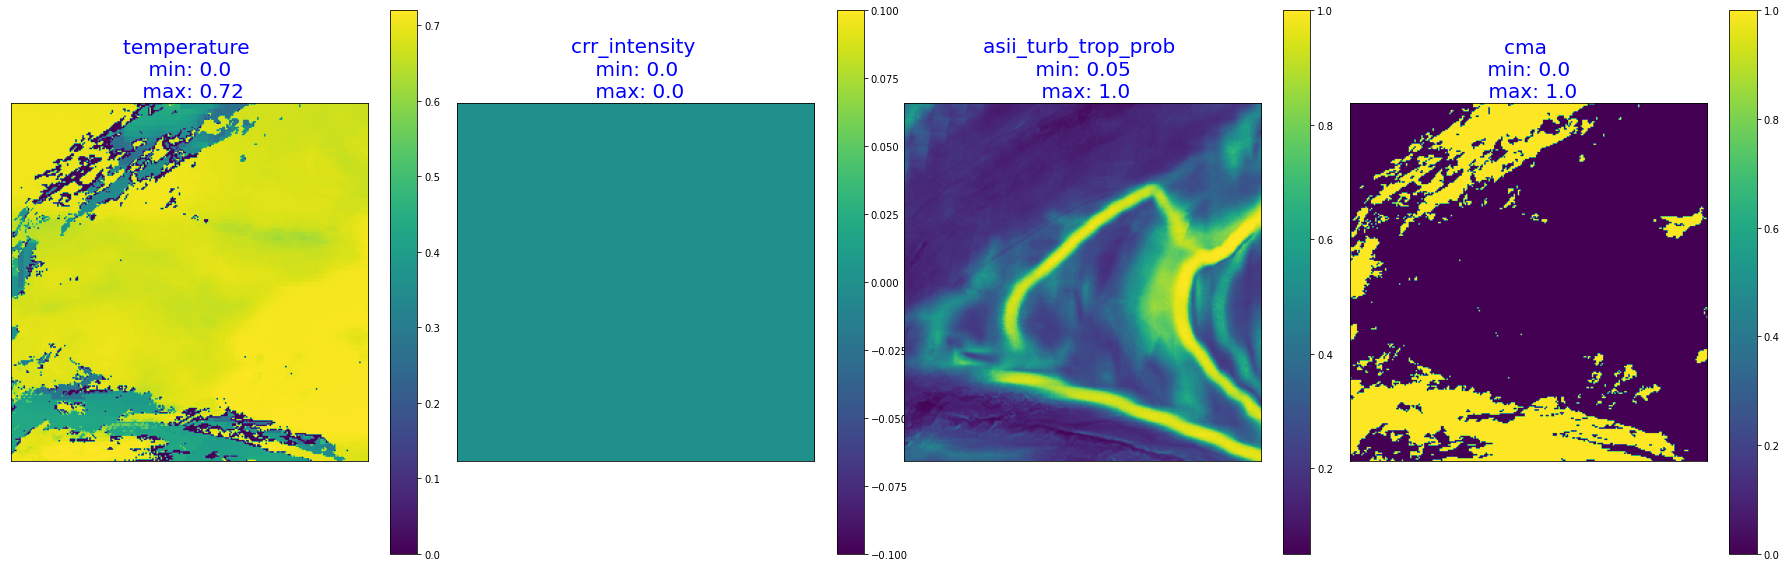

submission_examples/Persistence_submission/core-w4c/R3/test/2019047.h5


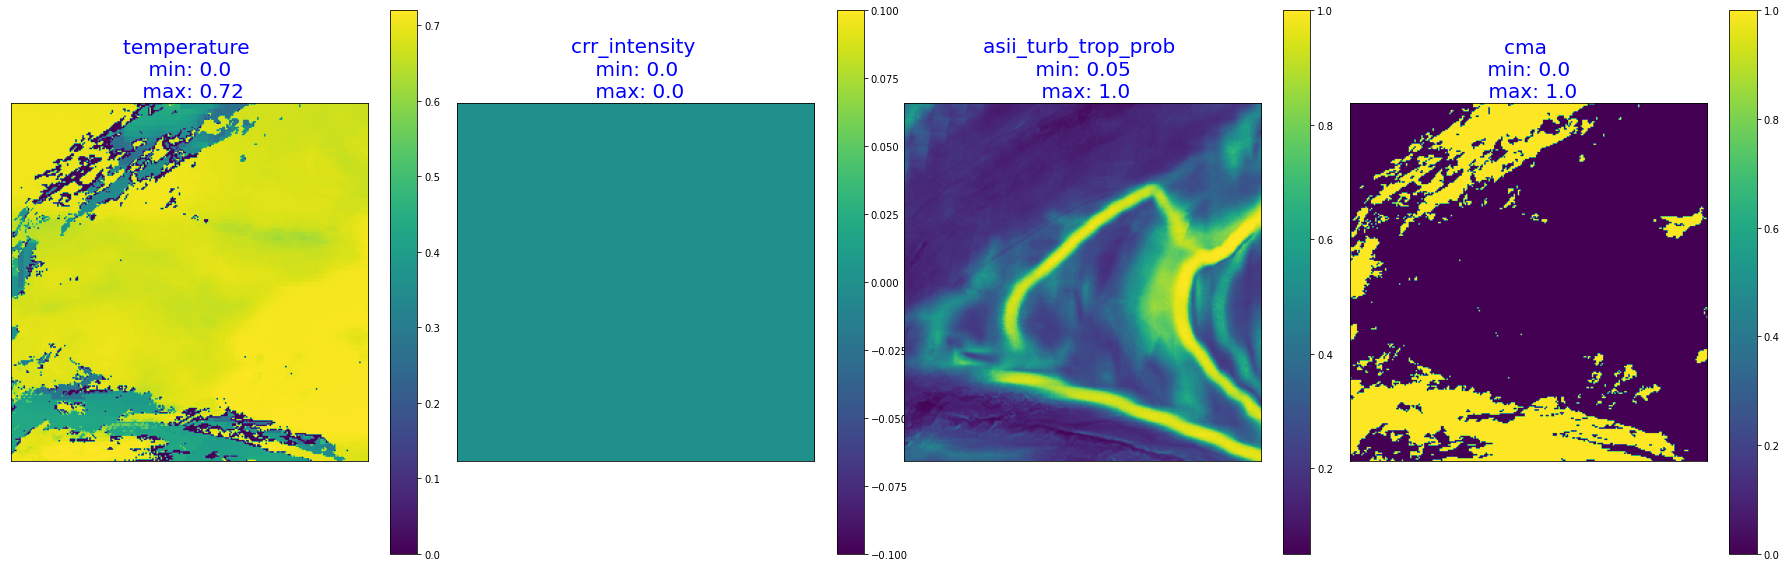

In [19]:
# 1. create our dataset for the desired data split and region (test & R1) 
data_split = 'test'
params['collapse_time'] = False
params['extra_data'] = ''
ds = create_dataset(data_split, params)

# 2. Create a dataloader
dataloader = DataLoader(ds, batch_size=32, shuffle=False, num_workers=0)

# 3. Get the target variables from the config file
target_vars = params['target_vars']

# 4. get the dates for the test split and create an iterator for the dataset
test_dates = data_splits[data_splits.split=='test'].id_date.sort_values().values
ds_iterator = iter(dataloader)

# 5. define a function to get next batch (the 32 inputs for a specific date) and create the slices as predictions
def persistence_mk_preds(iterator):
    """ create the slices as predictions and return them together with the target day_in_year """
    batch = next(iterator)
    in_seq, out, metadata = batch
    day_in_year = metadata['in']['day_in_year'][0][0].item()
    
    y_hat = in_seq[:, -1, :len(target_vars), ...]
    y_hat = y_hat.numpy()    
    
    return y_hat, day_in_year

# 6. make a prediction & show its shape
y_hat, predicted_day = persistence_mk_preds(ds_iterator)
print(f'The 32 predictions for date {predicted_day} have the shape: {y_hat.shape}')

# 7. Plot the first to get an idea of what we have (all are actually the same with the persistence model)
def plot_1_pred(data, target_vars, lead_time=0):
    images, texts = [], []
    for i in range(y_hat.shape[1]):
        images.append(data[lead_time, i])
        texts.append(f'{target_vars[i]} \n min: {str(data[lead_time, i].min())[:4]} \n max: {str(data[lead_time, i].max())[:4]}')
    plot_N(images, texts)
plot_1_pred(y_hat, target_vars)

# 8. post-process each variable and save it as predicted_day.h5 in uint16 format
file_path = f'submission_examples/Persistence_submission/core-w4c/{params["region_id"]}/test/{predicted_day}.h5'
y_hat_post = data_utils.postprocess_fn(np.copy(y_hat), target_vars, params['preprocess']['source'])
print(file_path)
data_utils.write_data(y_hat_post, file_path)

# 9. read the h5 file, preprocess it (un-pack variable ranges & normalize) & plot
y_hat_from_h5 = data_utils.read_h5_predictions(file_path)
scaled_y_hat_from_h5 = data_utils.scale_h5_variables(y_hat_from_h5.copy(), target_vars, 
                                                     params['preprocess']['source'])
plot_1_pred(scaled_y_hat_from_h5, target_vars)

# 10. Check that the predicted tensor is the same as the loaded and scaled tensor
assert (y_hat_post-y_hat_from_h5).sum() == 0, "Error, saved & loaded files are different!"
assert (y_hat-scaled_y_hat_from_h5).sum() == 0, "Error, saved/loaded normalized files are different!"

Lets now iterate across the whole dataset (all prediction dates), slice the last condition for all variables and save them into memory as a valid submission

In [20]:
ds_iterator = iter(dataloader)

for target_date in test_dates:
    print(f'generating submission for date: {target_date}...')
    y_hat, predicted_day = persistence_mk_preds(ds_iterator)

    # batches are sorted by date for the dataloader, that's why they coincide
    assert predicted_day==target_date, f"Error, the loaded date {predicted_day} is different than the target: {target_date}"
    
    file_path = f'submission_examples/Persistence_submission/core-w4c/{params["region_id"]}/test/{predicted_day}.h5'
    y_hat = data_utils.postprocess_fn(y_hat, target_vars, params['preprocess']['source'])
    data_utils.write_data(y_hat, file_path)
    print(f'--> saved in: {file_path}')

generating submission for date: 2019047...
--> saved in: submission_examples/Persistence_submission/core-w4c/R3/test/2019047.h5
generating submission for date: 2019073...
--> saved in: submission_examples/Persistence_submission/core-w4c/R3/test/2019073.h5
generating submission for date: 2019082...
--> saved in: submission_examples/Persistence_submission/core-w4c/R3/test/2019082.h5
generating submission for date: 2019092...
--> saved in: submission_examples/Persistence_submission/core-w4c/R3/test/2019092.h5
generating submission for date: 2019098...
--> saved in: submission_examples/Persistence_submission/core-w4c/R3/test/2019098.h5
generating submission for date: 2019104...
--> saved in: submission_examples/Persistence_submission/core-w4c/R3/test/2019104.h5
generating submission for date: 2019110...
--> saved in: submission_examples/Persistence_submission/core-w4c/R3/test/2019110.h5
generating submission for date: 2019114...
--> saved in: submission_examples/Persistence_submission/core

We have just computed a valid submission for a region. Now we should do the same for all other regions and then submit a zip containing the folders that contain the regions and we are done. Please, follow the instructions in weather4cast/README.md to generate the zip file.

### The following piece of code can compute the persistence submission for all regions at once in the **core competition**:

In [20]:
EVAL_PHASE = False # set to True for the held-out dataset at the end of the competition

for i in [1, 2, 3, 7, 8]:
    # set region and paths
    region = f'R{i}'
    print(f'\n region {region}')
    config_args = {
        'region_id': region, # region to be used, make sure you have download the data for the corresponding competition
    }
    params = cf.get_params(**config_args)['data_params']
    transfer = False

    # 1. create our dataset for the desired data split and region
    data_split = 'test'
    params['collapse_time'] = False
    params['extra_data'] = ''
    ds = create_dataset(data_split, params)

    # 2. Create a dataloader
    dataloader = DataLoader(ds, batch_size=32, shuffle=False, num_workers=0)

    # 3. Get the target variables from the config file
    target_vars = params['target_vars']

    # 4. get the dates for the test split and create an iterator for the dataset
    test_dates = data_splits[data_splits.split=='test'].id_date.sort_values().values
    ds_iterator = iter(dataloader)

    ds_iterator = iter(dataloader)
    for target_date in test_dates:
        print(f'generating submission for date: {target_date}...')
        y_hat, predicted_day = persistence_mk_preds(ds_iterator)
        
        competition = 'core'
        if transfer:
            competition = 'transfer-learning'
        if EVAL_PHASE:
            competition += '-heldout'
            target_date = sum_1_year(target_date)
        file_path = f'submission_examples/Persistence_submission/{competition}-w4c/{params["region_id"]}/test/{predicted_day}.h5'

        # batches are sorted by date for the dataloader, that's why they coincide
        assert predicted_day==target_date, f"Error, the loaded date {predicted_day} is different than the target: {target_date}"
            
        y_hat = data_utils.postprocess_fn(y_hat, target_vars, params['preprocess']['source'])
        data_utils.write_data(y_hat, file_path)
        print(f'--> saved in: {file_path}')
    
print('Done!')


 region R7
Using data for region R7 | size: 256 | Bosphorus
generating submission for date: 2019047...
--> saved in: submission_examples/Persistence_submission/core-w4c/R7/test/2019047.h5
generating submission for date: 2019073...
--> saved in: submission_examples/Persistence_submission/core-w4c/R7/test/2019073.h5
generating submission for date: 2019082...
--> saved in: submission_examples/Persistence_submission/core-w4c/R7/test/2019082.h5
generating submission for date: 2019092...
--> saved in: submission_examples/Persistence_submission/core-w4c/R7/test/2019092.h5
generating submission for date: 2019098...
--> saved in: submission_examples/Persistence_submission/core-w4c/R7/test/2019098.h5
generating submission for date: 2019104...
--> saved in: submission_examples/Persistence_submission/core-w4c/R7/test/2019104.h5
generating submission for date: 2019110...
--> saved in: submission_examples/Persistence_submission/core-w4c/R7/test/2019110.h5
generating submission for date: 2019114...


### Let us also compute the persistence predictions for the **transfer learning competition**

In [21]:
EVAL_PHASE = False # set to True for the held-out dataset at the end of the competition

for i in [4, 5, 6, 9, 10, 11]:
    # set region and paths
    region = f'R{i}'
    print(f'\n region {region}')
    config_args = {
        'region_id': region, # region to be used, make sure you have download the data for the corresponding competition
    }
    params = cf.get_params(**config_args)['data_params']
    transfer = True

    # 1. create our dataset for the desired data split and region
    data_split = 'test'
    params['collapse_time'] = False
    params['extra_data'] = ''
    ds = create_dataset(data_split, params)

    # 2. Create a dataloader
    dataloader = DataLoader(ds, batch_size=32, shuffle=False, num_workers=0)

    # 3. Get the target variables from the config file
    target_vars = params['target_vars']

    # 4. get the dates for the test split and create an iterator for the dataset
    test_dates = data_splits[data_splits.split=='test'].id_date.sort_values().values
    ds_iterator = iter(dataloader)

    ds_iterator = iter(dataloader)
    for target_date in test_dates:
        print(f'generating submission for date: {target_date}...')
        y_hat, predicted_day = persistence_mk_preds(ds_iterator)
        
        competition = 'core'
        if transfer:
            competition = 'transfer-learning'
        if EVAL_PHASE:
            competition += '-heldout'
            target_date = sum_1_year(target_date)
        file_path = f'submission_examples/Persistence_submission/{competition}-w4c/{params["region_id"]}/test/{predicted_day}.h5'

        # batches are sorted by date for the dataloader, that's why they coincide
        assert predicted_day==target_date, f"Error, the loaded date {predicted_day} is different than the target: {target_date}"
            
        y_hat = data_utils.postprocess_fn(y_hat, target_vars, params['preprocess']['source'])
        data_utils.write_data(y_hat, file_path)
        print(f'--> saved in: {file_path}')
    
print('Done!')


 region R4
Using data for region R4 | size: 256 | Central
Maghreb
generating submission for date: 2019047...
--> saved in: submission_examples/Persistence_submission/transfer-learning-w4c/R4/test/2019047.h5
generating submission for date: 2019073...
--> saved in: submission_examples/Persistence_submission/transfer-learning-w4c/R4/test/2019073.h5
generating submission for date: 2019082...
--> saved in: submission_examples/Persistence_submission/transfer-learning-w4c/R4/test/2019082.h5
generating submission for date: 2019092...
--> saved in: submission_examples/Persistence_submission/transfer-learning-w4c/R4/test/2019092.h5
generating submission for date: 2019098...
--> saved in: submission_examples/Persistence_submission/transfer-learning-w4c/R4/test/2019098.h5
generating submission for date: 2019104...
--> saved in: submission_examples/Persistence_submission/transfer-learning-w4c/R4/test/2019104.h5
generating submission for date: 2019110...
--> saved in: submission_examples/Persistenc